# Case Study
For this case study, we will use the Car Seats dataset to predict the sales of car seats in US. The goal is to show how decision trees can model a regression problem (predicting sales).

In [2]:
import sys
!{sys.executable} -m pip install graphviz
print('Done.')

Done.


In [3]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [4]:
# load and display dataset
carseats_df = pd.read_csv('Carseats.csv')

carseats_df.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## Data Cleaning
Real world datasets are always messy (far messier that the one used for this case study). Before we do any analysis, we should do some data cleaning to ensure that the data is ready for analysis.
Some of the cleaning steps are
- Checking for missing values
- Checking for ourliers and using an appropriate strategy to handle them
- Encode any string variables with floats so that the algorithms can use those variables

In this case, there is an unnecessary 'Unnamed: 0' column. We need to get rid of this.

In [5]:
carseats_df = carseats_df.drop('Unnamed: 0', axis=1)

carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


### Missing values
Check for missing values

In [6]:
carseats_df.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

### Check feature types
Check if there are any features that have values other floats. These features will need to be encoded so that they can used appropriately in ML algorithms

In [7]:
carseats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


Looks like we have three features, ShelveLoc, Urban and US, which take on non-float values (shown by the category 'object'). Let's check what are the unique values for each of these features

In [8]:
cat_cols = ['ShelveLoc', 'Urban', 'US']
for col in cat_cols:
    print('{}: {}'.format(col, carseats_df[col].unique()))

ShelveLoc: ['Bad' 'Good' 'Medium']
Urban: ['Yes' 'No']
US: ['Yes' 'No']


## Feature Encoding
We need to encode the categorical features to some floats. The simplest form of encoding is called 'One-hot encoding'. One-hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

The figure below explains the difference between label encoding and one-hot encoding.

![Label Encoding vs. One-hot Encoding](https://miro.medium.com/max/2736/0*T5jaa2othYfXZX9W.)

In [9]:
X = carseats_df.drop(['Sales'], axis = 1)
y = carseats_df['Sales']

# this step does the feture encoding for us
X = pd.get_dummies(X)

X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0


### Train-test split
Reserve 30% of the data for testing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train features shape: {}'.format(X_train.shape))
print('Train labels shape: {}'.format(y_train.shape))
print('Test features shape: {}'.format(X_test.shape))
print('Test labels shape: {}'.format(y_test.shape))

Train features shape: (280, 14)
Train labels shape: (280,)
Test features shape: (120, 14)
Test labels shape: (120,)


### Machine Learning
Fit a Decision Tree model with max_depth = 5 and test MSE and RMSE on the test set

In [11]:
# Fit Sklearn's tree regressor
clf = tree.DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

# Measure test set MSE
y_pred = clf.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)

# Get proportion of correct classifications on test set
print('Test MSE: {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

Test MSE: 4.844
Test RMSE: 2.201


### Improving MSE
We can use cross-validation to optimize the max_depth hyperparameter. Remember that setting this too low results in underfitting and setting this too high results in overfitting.

We will use 10-fold cv on the training set to choose the best value of this hyperparameter. Then we will use the best value to make predictions on the test dataset

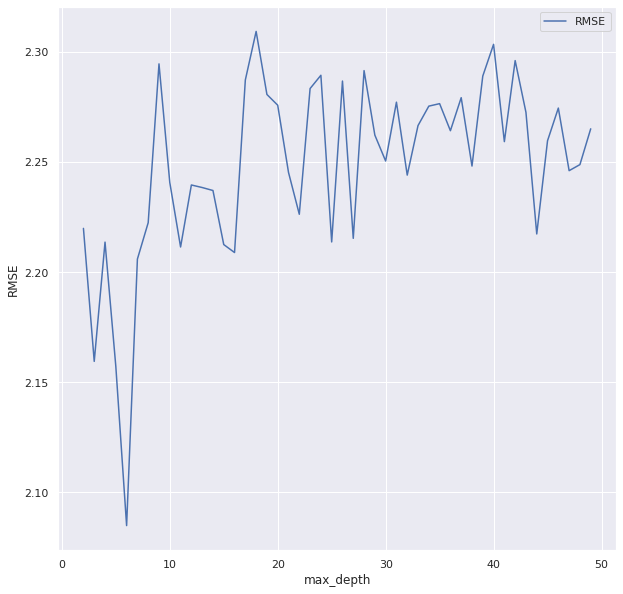

               RMSE
max_depth          
6.0        2.084836
Test MSE : 4.012
Test RMSE: 2.003


In [12]:

cv_folds = 10
tuning_param = 'max_depth'
columns=[tuning_param, 'RMSE']

results = []
for m in np.arange(2, 50):
    regr = tree.DecisionTreeRegressor(max_depth=m)
    scores = cross_val_score(regr, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    results += [[m, rmse]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
print(chosen)

# Use chosen model for test prediction
regr  = tree.DecisionTreeRegressor(max_depth=int(chosen.index[0])).fit(X_train, y_train)
y_pred = regr.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

### Bagging
A single decision tree is almost always avoided due to its tendency to overfit. As we learned in the class, a better approach is to use a Bagging strategy. In this case, we create 10 bootstrap samples and fit 10 decision trees on them. Their predictions are averaged to determine the final prediction.

Let's check if this improves our MSE.

In [13]:
# Bagging with 10 trees

max_features = X.shape[1]

regr = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=10)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(rmse, 3)))

Test MSE : 2.85
Test RMSE: 1.688


We can see that our MSE is lower on the test set with a bagging approach

## Variable Importance plots
Tree models provide us the ability to look at different features and their importance when fitting the training dataset. We can use these importance plots to see which features are contributing towards the training data fit. This interpretability is very useful as it helps us in explaining the model to a business audience.

We can also use these plots to choose the top-X features and use them to refit the model. 

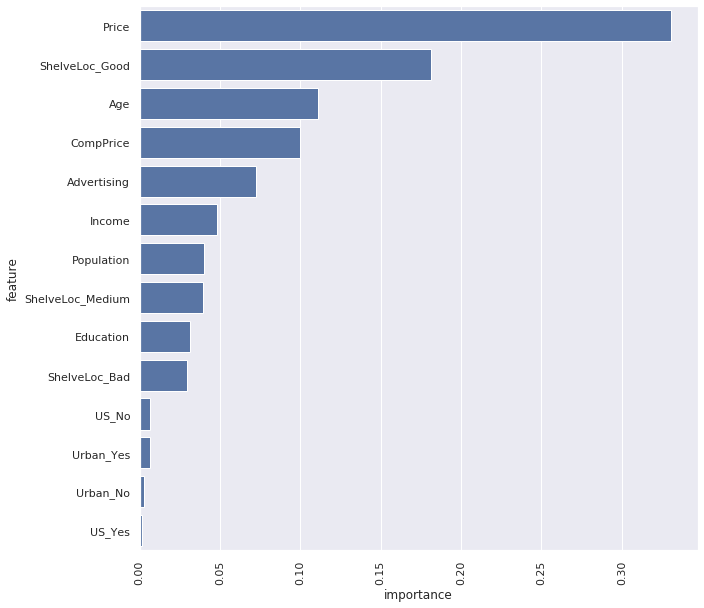

In [14]:
plot_df = pd.DataFrame({'feature': X.columns, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

#### Remove Variables with Least Importance
We can refit the training data with a bagging strategy by dropping the 'Urban' and 'US' variables. If we do not see a significant increase in MSE after dropping features, we can exclude those features.

In this case, this leads to a better MSE (not always the case in every dataset)

In [15]:
X = carseats_df.drop(['Sales', 'Urban', 'US'], axis = 1)
y = carseats_df['Sales']

# this step does the feture encoding for us
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Bagging with 10 trees

max_features = X.shape[1]

regr = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=10)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(rmse, 3)))

Test MSE : 2.698
Test RMSE: 1.643


# Exercise
Visualize the fitted tree using [sklearn.tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) library